In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import random
from osgeo import gdal
import os
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##1. Xử lý file dữ liệu trạm


Trạm Thanh Hóa

Longtitude: 105.281389

Latitude: 19.832222

Time: GMT+0

In [ ]:
df = pd.read_excel('/content/drive/My Drive/RainData/Station/BacTrungBoStation.xlsx')
date_time = pd.to_datetime(pd.Series(df['Thời Gian']))
date_time = date_time.dt.round(freq = 'S')
df['ngày'] = date_time.dt.date
df['giờ'] = date_time.dt.time
df[df['Tỉnh'] == 'Thanh Hóa'].sort_values(by=['ngày', 'giờ']).drop(columns=['Tên Trạm', 'Kinh độ', 'Vĩ độ', 'Xã', 'Huyện', 'Tỉnh', 'Loại dữ liệu', 'Thời Gian địa phương', 'Thời Gian'])

## 2. Phân tích dữ liệu

In [ ]:
df = pd.read_excel('/content/drive/My Drive/RainData/Station/ThanhHoaStation.xlsx')

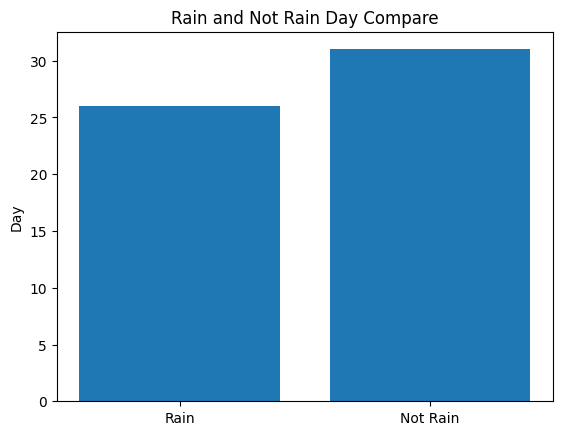

In [ ]:
plt.bar(['Rain', 'Not Rain'],\
        [len(df[df['Giá trị'] != 0]['ngày'].dt.day.unique()) ,\
         len(df[df['Giá trị'] == 0]['ngày'].dt.day.unique())],\
        align='center')
plt.ylabel('Day')
plt.title('Rain and Not Rain Day Compare')
plt.show()

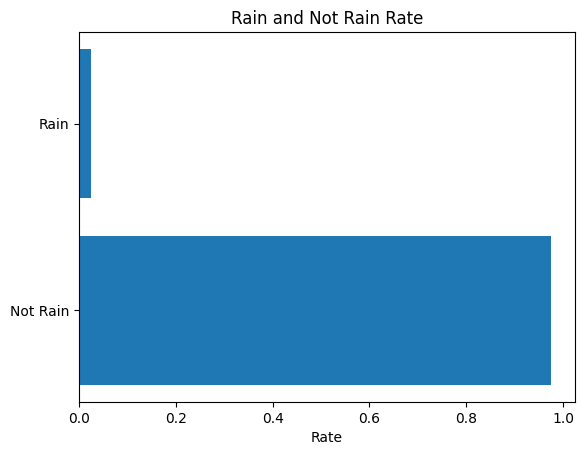

In [ ]:
stt = ['Rain', 'Not Rain']
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(len(stt))
not_rain_num = len(df[df['Giá trị'] == 0])
rain_num = len(df[df['Giá trị'] != 0])
ratio = np.array([rain_num / (not_rain_num + rain_num), not_rain_num / (not_rain_num + rain_num)])
ax.barh(y_pos, ratio, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(stt)
ax.invert_yaxis()
ax.set_xlabel('Rate')
ax.set_title('Rain and Not Rain Rate')
plt.show()

## 3. Triết xuất đặc trưng


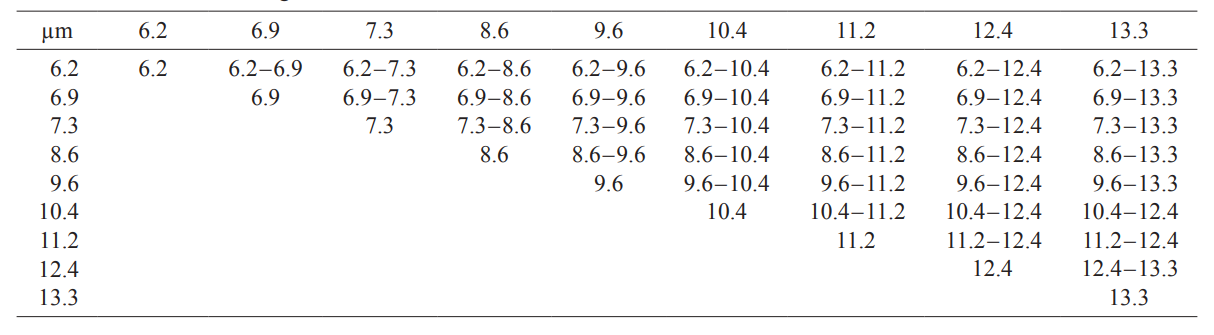

In [ ]:
m62, m69, m73, m86, m96, m104, m112, m124, m133 = [], [], [], [], [], [], [], [], []
m = [m62, m69, m73, m86, m96, m104, m112, m124, m133]
# Lấy ra các đặc trưng thuần
def org_feature():
  for i in range(len(df)):
    # get all bands
    for b in range(8, 17):
      band = 'tbb_' + str(b).rjust(2, '0')
      day = str(df.iloc[i, 1].day).rjust(2, '0')
      time = ''.join(str(df.iloc[i, 2]).split(':')[:-1])
      path = '/content/drive/My Drive/RainData/ThanhHoaTiff/' + band + '/' + day + '/NC_H08_201908' + day + '_' + time + '_R21_FLDK.02401_02401_band' + str(b) + '_clipped.tif'

      # Nếu dòng dữ liệu ko có dữ liệu ảnh tương ứng thì ta fill np.nan vào đó
      if os.path.isfile(path) == False:
        m[b - 8].append(np.nan)
        continue
      
      ds = gdal.Open(path)
      if ds is None:
        m[b - 8].append(np.nan)
      else: 
        ds_band = ds.GetRasterBand(1)
        gt = ds.GetGeoTransform()
        ds_arr = ds.ReadAsArray().astype(np.float64)
        # Chuyển đổi Kinh độ, Vĩ độ sang tọa độ trên raster map
        lat, lon = 19.832222, 105.281389
        offset_x = int((lat - gt[3])/gt[5])
        offset_y = int((lon - gt[0])/gt[1])
        # Lấy đặc trưng
        m[b - 8].append(ds_arr[offset_x, offset_y])

In [ ]:
org_feature()

In [ ]:
df['6.2'] = pd.Series(np.array(m62))
df['6.9'] = pd.Series(np.array(m69))
df['7.3'] = pd.Series(np.array(m73))
df['8.6'] = pd.Series(np.array(m86))
df['9.6'] = pd.Series(np.array(m96))
df['10.4'] = pd.Series(np.array(m104))
df['11.2'] = pd.Series(np.array(m112))
df['12.4'] = pd.Series(np.array(m124))
df['13.3'] = pd.Series(np.array(m133))

In [ ]:
# Trích chọn các đặc trưng delta bands
mband = ['6.2', '6.9', '7.3', '8.6', '9.6', '10.4', '11.2', '12.4', '13.3']
for i in range(1, len(mband)):
  for j in range(0, i):
    df[mband[j] + '-' + mband[i]] = df[mband[j]] - df[mband[i]]

In [ ]:
df.drop(columns=['ngày', 'giờ']).dropna().to_csv('/content/drive/My Drive/RainData/Station/Dataset.csv', index = False)